<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

#  Цель исследования

Построить модель предсказания количества заказов такси на следующий час. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

#  Описание данных

- `datetime` - дата
- `num_orders` - количество заказов

#  Этапы исследования

1.  Подготовка
2.  Анализ
3.  Обучение
4.  Тестирование

## Подготовка

In [ ]:
# импортируем нужные библиотеки

import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
# сохраним данные в переменную data

data = pd.read_csv('***')

In [ ]:
# посмотрим первые 5 строк датасета

data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [ ]:
# общая информация о данных

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Колонка с датой и временем имеет строковое значение. Для дальнейшей работы изменим на тип `datetime64`. 

In [ ]:
data['datetime'] = data['datetime'].astype('datetime64')

In [ ]:
# устанавливаем колонку datetime в качестве индекса

data.set_index('datetime', inplace=True)

In [ ]:
# сортируем по дате и времени

data.sort_index(inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
# ресемплируем данные по 1 часу, значения суммируем

data = data.resample('1H').sum()

In [ ]:
# снова смотрим на первые 5 строк

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод**

Пропусков в данных нет. Произвели ресемплирование по 1 часу.

## Анализ

In [ ]:
# разложим временной ряд на тренд, сезонность и остаток 

decomposed = seasonal_decompose(data)

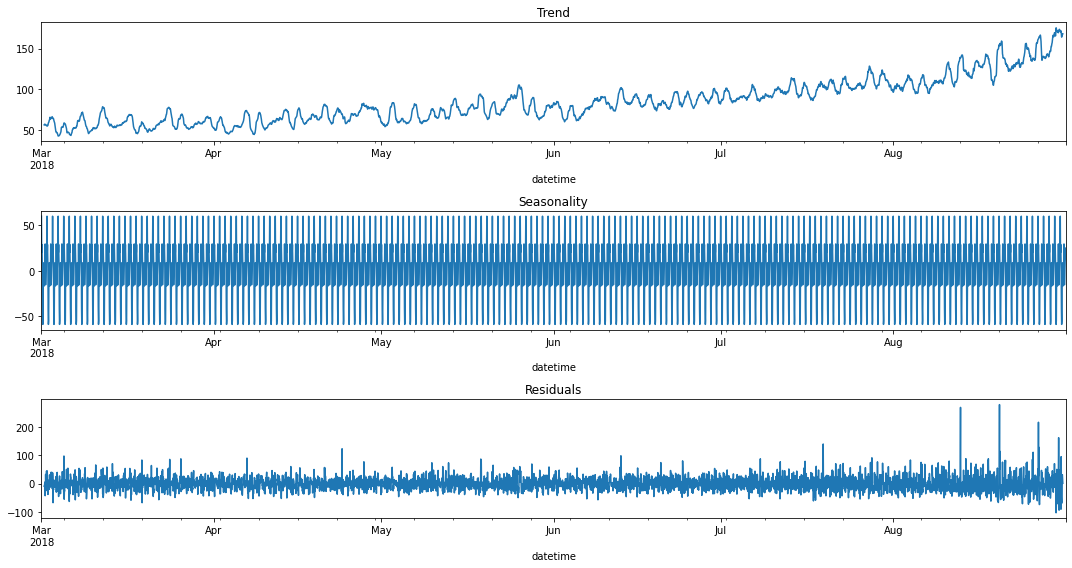

In [ ]:
# строим графики тренда, сезонности и остатока 

plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд проявляется в том, что с апреля по конец августа (далее данных нет) число заказов растет. Сезонность связана с периодом меньше недели. Остатки необъяснимы. Посмотрим ближе на сезонность.

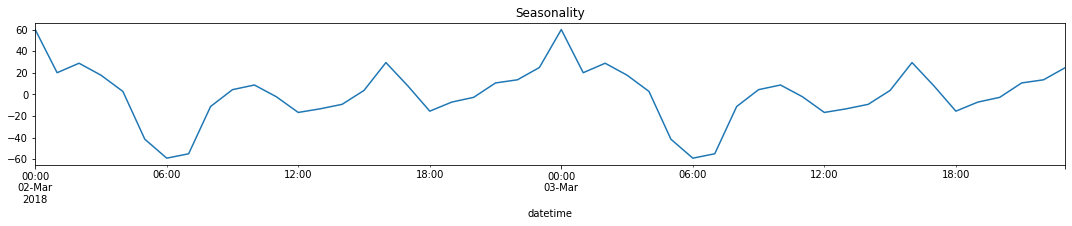

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(312)
decomposed.seasonal['2018-03-02':'2018-03-03'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout();

Сезонность - 1 сутки: пик заказов в 00:00, минимум рано утром в 06:00. С 06:00 рост с постепенным плавным снижением к 12:00, затем снова рост к 16:00 с последующим резким снижением к 18:00, и затем рост до пикового значения в 00:00.

Проверим стационарность ряда. Добавим колонки со скользящим средним и стандартным отклонением с окном в 24 часа.

In [ ]:
data['mean'] = data['num_orders'].rolling(24).mean()
data['std'] = data['num_orders'].rolling(24).std()

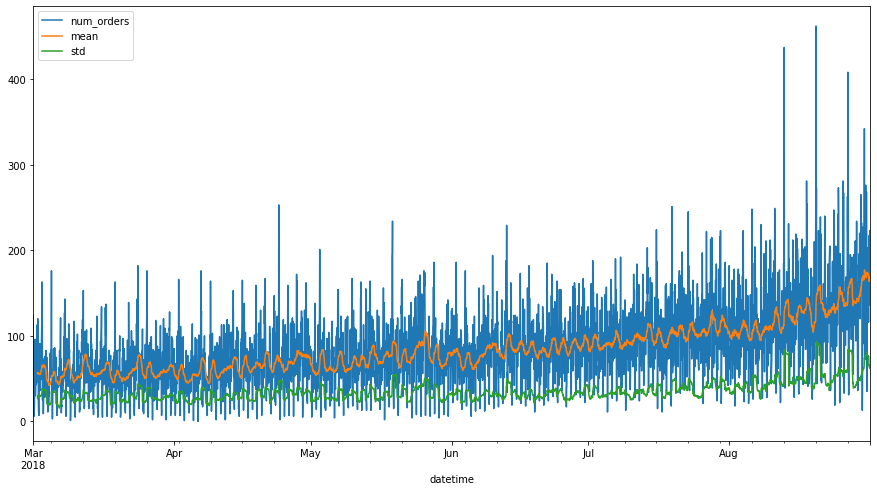

In [ ]:
data.plot(figsize=(15, 8));

Изобразим только среднее и отклонение.

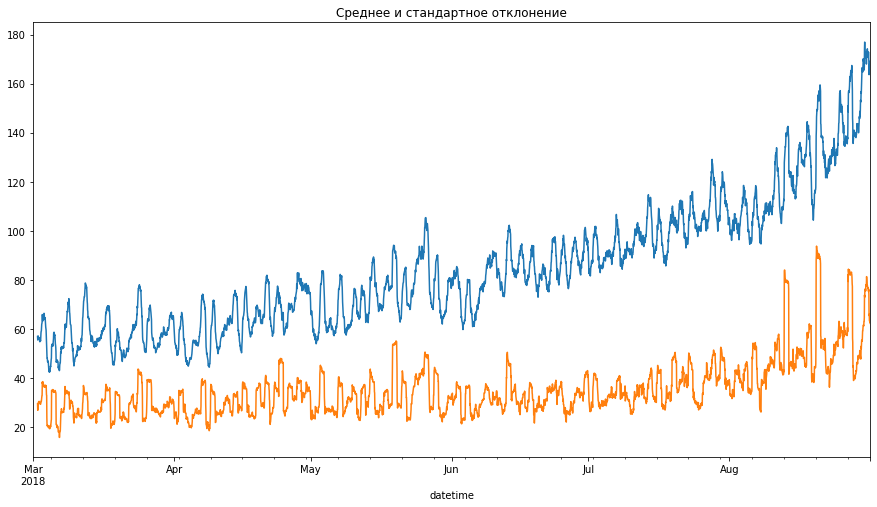

In [ ]:
data['mean'].plot(figsize=(15, 8), label='mean')
data['std'].plot(figsize=(15, 8), label='std')
plt.title('Среднее и стандартное отклонение');

Може сделать вывод, что временной ряд нестационарный: страндартное отклонение и среднее меняются.

**Вывод**

Временной ряд нестационарный: страндартное отклонение и среднее меняются. Сезонность суточная: пик в 00:00, минимум в 06:00. Тренд: рост заказов с апреля по конец августа.

## Обучение

In [ ]:
# удалим ненужные колонки из предыдушего шага

data = data.drop(['mean', 'std'], axis=1)

In [ ]:
# напишем функцию создания новых переменных

def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    df = data.copy()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

Окно для среднего логично взять сутки, т.е. 24 часа, а лаг возмем 24*7, т.е. 168, чтобы модель могла учесть значения других дней в течение недели.

In [ ]:
df = make_features(data, 168, 24)

Подготовим выборки к обучению моделей.

In [ ]:
train, valid = train_test_split(df, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid, shuffle=False, test_size=0.5)

In [ ]:
train = train.dropna()

In [ ]:
features_train = train.drop('num_orders',  axis=1)
target_train = train['num_orders']

features_valid = valid.drop('num_orders',  axis=1)
target_valid = valid['num_orders']

features_test = test.drop('num_orders',  axis=1)
target_test = test['num_orders']

Обучим модели Лассо, Случайный лес, CatBoost.

In [ ]:
# напишем фунцию для обучения и оценки моделей

def model_estimator(model, params, features_train, target_train, features_valid, target_valid):
    tscv = TimeSeriesSplit()
    model = RandomizedSearchCV(model, params, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    model.fit(features_train, target_train)
    print('Лучшие гиперпараметры:', model.best_params_)
    model = model.best_estimator_
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    print('RMSE:', mean_squared_error(target_valid, predictions)**0.5)

**Лассо**

In [ ]:
lasso = Lasso(random_state=12345)
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
model_estimator(lasso, lasso_params, features_train, target_train, features_valid, target_valid)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7409.9239716263255, tolerance: 323.03582496433665
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278944.3261441334, tolerance: 428.8376000000002
  model = cd_fast.enet_coordinate_descent(


Лучшие гиперпараметры: {'alpha': 0.03}
RMSE: 28.089706251018335


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278944.3261441334, tolerance: 428.8376000000002
  model = cd_fast.enet_coordinate_descent(


**Случайный лес**

In [ ]:
rf = RandomForestRegressor(random_state=12345)
rf_params = {'n_estimators': range(10, 61, 10), 'max_depth': range(1, 10)}
model_estimator(rf, rf_params, features_train, target_train, features_valid, target_valid)

Лучшие гиперпараметры: {'n_estimators': 60, 'max_depth': 9}
RMSE: 30.076047177196696


**CatBoost**

In [ ]:
cb = CatBoostRegressor(random_state=12345, verbose=0)
cb_params = {'learning_rate':[0.01, 0.05, 0.1], 'iterations': [100, 200, 500], 'depth': [4, 6, 10]}
model_estimator(cb, cb_params, features_train, target_train, features_valid, target_valid)

Лучшие гиперпараметры: {'learning_rate': 0.05, 'iterations': 500, 'depth': 4}
RMSE: 29.032533563365416


**Вывод**

Лучший результат на валидационной выборке показала модель Лассо с параметром `alpha` = 0.03. Эту модель будем тестировать.

## Тестирование

In [ ]:
# объединим обучающую и валидационную выборки

features_train = pd.concat([features_train, features_valid])
target_train = pd.concat([target_train, target_valid])

In [ ]:
# оценим результат лучшей модели на тестовой выборке

lasso = Lasso(alpha=0.03, random_state=12345)
lasso.fit(features_train, target_train)
predictions = lasso.predict(features_test)
print('RMSE:', mean_squared_error(target_test, predictions)**0.5)

RMSE: 35.39255064590174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 398658.7022134093, tolerance: 569.3793103783499
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# сравним с результатом глупой модели на тестовой выборке

dummy = DummyRegressor(strategy='mean')
dummy.fit(features_train, target_train)
dummy_predictions = dummy.predict(features_test)
print('RMSE:', (mean_squared_error(target_test, dummy_predictions)**0.5))

RMSE: 83.97941361168559


Визуализируем соотношение предсказаний лучшей модели и реальных значений.

In [ ]:
predictions = pd.Series(data=predictions, index=target_test.index)

In [ ]:
results = pd.DataFrame(data={'target_test':target_test, 'predictions':predictions})

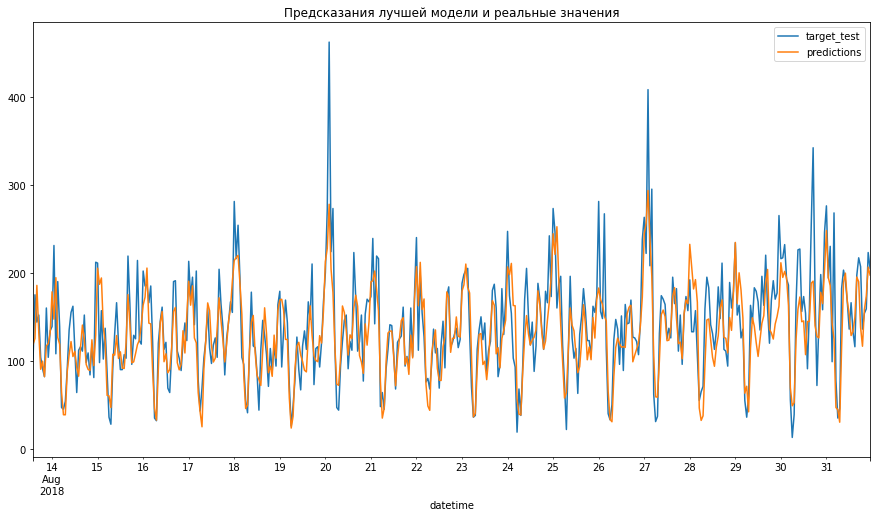

In [ ]:
results.plot(figsize=(15, 8))
plt.title('Предсказания лучшей модели и реальные значения');

Визуально предсказания лучшей модели находятся близко к реальным значениям.

**Вывод**

RMSE лучшей модели Лассо на тестовой выборке 35.4. RMSE глупой модели 83.9. Качество выбранной модели хорошее.

## Общий вывод

Для обучения модели создали дополнительные признаки: использовали лаг 168 для учета значений в течение недели, а также скользящую среднюю за 24 часа. Лучший результат на валидационной выборке показала модель Лассо с параматром alpha = 0.03 (RMSE = 28). RMSE лучшей модели на тестовой выборке 35.4.против 83.9 у глупой модели. Рекомендуется использовать модель Лассо с параматром alpha = 0.03.